#### Import

In [37]:
import os
import numpy as np
import glob
import PIL.Image as Image
import cv2
# pip install torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split


#### Config

In [38]:
class config:
    def __init__(self):
        self.img_size = 64 # org size mean 575 x 766
        self.batch_size = 4 #6
        self.seed = 42
        self.workers = 3 #3
        self.lr = 0.001
config = config()

#### PH2 Dataloader

In [39]:
class DRIVE(torch.utils.data.Dataset):
    def __init__(self,transform,idx_list):
        'Initialization'
        self.transform = transform
        self.data_path = "/dtu/datasets1/02516/DRIVE/training"
        self.image_paths = np.array(sorted(glob.glob(f"{self.data_path}/images/*.tif")))[idx_list]
        self.label_paths = np.array(sorted(glob.glob(f"{self.data_path}/1st_manual/*.gif")))[idx_list]

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(image_path)
        label = Image.open(label_path)
        
        Y = self.transform(label)
        X = self.transform(image)
        return X, Y
    

size = config.img_size
color_jit = [0.2, 0.15, 0.1, 0.15]
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.RandomRotation(degrees=(10, 100)),
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.RandomVerticalFlip(p=0.3),
                                      transforms.ColorJitter(*color_jit), 
                                    transforms.ToTensor()])
val_test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])



data_path = "/dtu/datasets1/02516/DRIVE/training"
image_paths = sorted(glob.glob(f"{data_path}/images/*.tif"))
train_idx,val_test_idx = train_test_split(list(range(len(image_paths))),train_size=0.6,random_state=42)
val_idx,test_idx = train_test_split(val_test_idx,train_size=0.5,random_state=42)

trainset = DRIVE(transform=train_transform,idx_list=train_idx)
valset = DRIVE(transform=val_test_transform,idx_list=val_idx)
testset = DRIVE(transform=val_test_transform,idx_list=test_idx)

train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
val_loader = DataLoader(valset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))

##### Check Dataloader

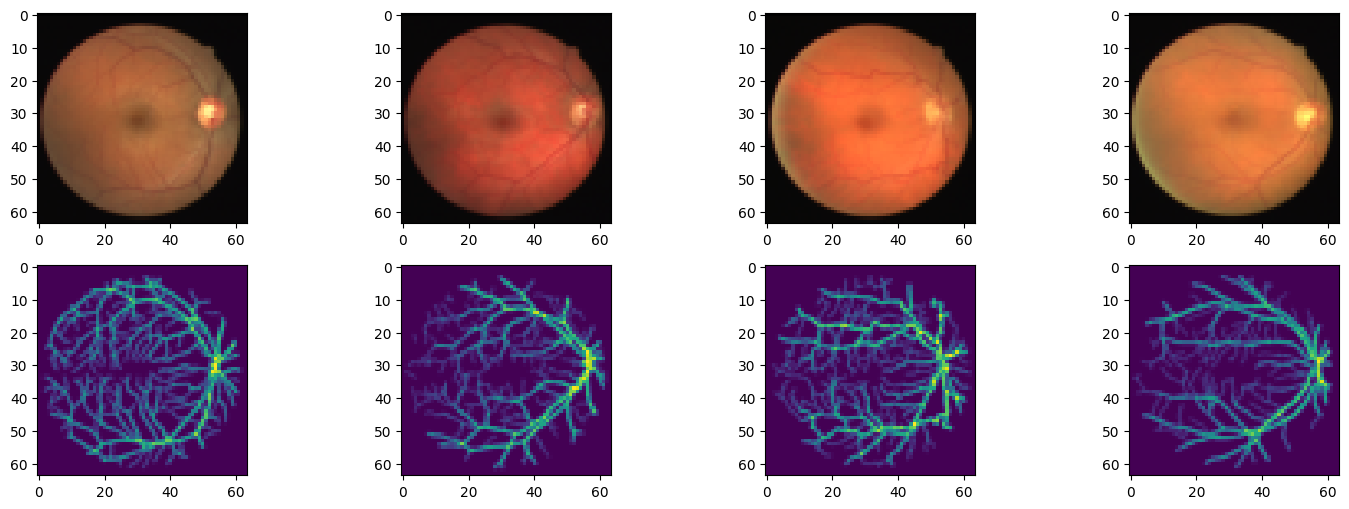

In [40]:
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))
val_images, val_labels = next(iter(val_loader))

plt.rcParams['figure.figsize'] = [18, 6]

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(val_images[i], 0, 2), 0, 1))

    plt.subplot(2, 4, i+5)
    plt.imshow(val_labels[i].squeeze())
plt.show()

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### EncDec

In [42]:
class EncDec(nn.Module):
    """
    Encoder-Decoder network for image segmentation.

    Args:
        None

    Attributes:
        enc_conv0 (nn.Conv2d): Convolutional layer for the first encoder block.
        pool0 (nn.MaxPool2d): Max pooling layer for downsampling.
        enc_conv1 (nn.Conv2d): Convolutional layer for the second encoder block.
        pool1 (nn.MaxPool2d): Max pooling layer for downsampling.
        enc_conv2 (nn.Conv2d): Convolutional layer for the third encoder block.
        pool2 (nn.MaxPool2d): Max pooling layer for downsampling.
        enc_conv3 (nn.Conv2d): Convolutional layer for the fourth encoder block.
        pool3 (nn.MaxPool2d): Max pooling layer for downsampling.
        bottleneck_conv (nn.Conv2d): Convolutional layer for the bottleneck block.
        upsample0 (nn.Upsample): Upsampling layer for the first decoder block.
        dec_conv0 (nn.Conv2d): Convolutional layer for the first decoder block.
        upsample1 (nn.Upsample): Upsampling layer for the second decoder block.
        dec_conv1 (nn.Conv2d): Convolutional layer for the second decoder block.
        upsample2 (nn.Upsample): Upsampling layer for the third decoder block.
        dec_conv2 (nn.Conv2d): Convolutional layer for the third decoder block.
        upsample3 (nn.Upsample): Upsampling layer for the fourth decoder block.
        dec_conv3 (nn.Conv2d): Convolutional layer for the final decoder block.

    Methods:
        forward(x): Performs forward pass through the network.

    """

    def __init__(self):
        super().__init__()

        inp_size = config.img_size//2
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, inp_size, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(inp_size, inp_size, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(inp_size, inp_size, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(inp_size, inp_size, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(inp_size, inp_size, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(inp_size, inp_size, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(inp_size, inp_size, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(inp_size, inp_size, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(inp_size, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

#### UNet with max pooling


In [43]:
class SimpleUNet(nn.Module):
    """
    UNet is a convolutional neural network architecture for image segmentation.
    It consists of an encoder (downsampling path) and a decoder (upsampling path).
    The encoder extracts high-level features from the input image, while the decoder
    reconstructs the segmented image from the extracted features.

    Args:
        None

    Attributes:
        enc_conv0 (nn.Conv2d): First convolutional layer in the encoder.
        pool0 (nn.MaxPool2d): First max pooling layer in the encoder.
        enc_conv1 (nn.Conv2d): Second convolutional layer in the encoder.
        pool1 (nn.MaxPool2d): Second max pooling layer in the encoder.
        enc_conv2 (nn.Conv2d): Third convolutional layer in the encoder.
        pool2 (nn.MaxPool2d): Third max pooling layer in the encoder.
        enc_conv3 (nn.Conv2d): Fourth convolutional layer in the encoder.
        pool3 (nn.MaxPool2d): Fourth max pooling layer in the encoder.
        bottleneck_conv (nn.Conv2d): Convolutional layer in the bottleneck.
        upsample0 (nn.Upsample): First upsampling layer in the decoder.
        dec_conv0 (nn.Conv2d): First convolutional layer in the decoder.
        upsample1 (nn.Upsample): Second upsampling layer in the decoder.
        dec_conv1 (nn.Conv2d): Second convolutional layer in the decoder.
        upsample2 (nn.Upsample): Third upsampling layer in the decoder.
        dec_conv2 (nn.Conv2d): Third convolutional layer in the decoder.
        upsample3 (nn.Upsample): Fourth upsampling layer in the decoder.
        dec_conv3 (nn.Conv2d): Fourth convolutional layer in the decoder.

    Methods:
        forward(x): Performs forward pass through the UNet model.

    Returns:
        d3 (torch.Tensor): Output tensor of the UNet model.
    """

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(self.pool0(e0)))
        e2 = F.relu(self.enc_conv2(self.pool1(e1)))
        e3 = F.relu(self.enc_conv3(self.pool2(e2)))
        e4 = self.pool3(e3)
        # bottleneck
        b = F.relu(self.bottleneck_conv(e4))
        
        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1)))
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1))
        return d3

#### GeneralUNet

In [44]:
import torch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchsummary import summary


def create_block(in_channels:int,out_channels,padding:int=0):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding,stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding,stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return block


class UNET(nn.Module):
    def __init__(self, in_ch, out_ch,upsample_type='transpose'):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.factor = 2 if upsample_type == 'bilinear' else 1

        self.d1 = create_block(in_channels=in_ch,out_channels=64,padding=1)
        self.d2 = create_block(in_channels=64,out_channels=128,padding=1)
        self.d3 = create_block(in_channels=128,out_channels=256,padding=1)
        self.d4 = create_block(in_channels=256,out_channels=512,padding=1)
        self.bottleneck = create_block(in_channels=512,out_channels=1024//self.factor,padding=1)


        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.u1_conv = create_block(in_channels=1024,out_channels=512//self.factor,padding=1)
        self.u2_conv = create_block(in_channels=512,out_channels=256//self.factor,padding=1)
        self.u3_conv = create_block(in_channels=256,out_channels=128//self.factor,padding=1)
        self.u4_conv = create_block(in_channels=128,out_channels=64,padding=1)

        if upsample_type == 'transpose':
            self.u1 = nn.ConvTranspose2d(1024, 512//self.factor, kernel_size=2, stride=2)
            self.u2 = nn.ConvTranspose2d(512, 256//self.factor, kernel_size=2, stride=2)
            self.u3 = nn.ConvTranspose2d(256, 128//self.factor, kernel_size=2, stride=2)
            self.u4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        elif upsample_type == 'bilinear':
            self.u1 = nn.Upsample(scale_factor=2,mode='bilinear')
            self.u2 = nn.Upsample(scale_factor=2,mode='bilinear')
            self.u3 = nn.Upsample(scale_factor=2,mode='bilinear')
            self.u4 = nn.Upsample(scale_factor=2,mode='bilinear')

        self.out = nn.Conv2d(64, out_ch, kernel_size=1)


    def forward(self, x):
        down1 = self.d1(x) 
        x = self.maxpool(down1)  

        down2 = self.d2(x)  
        x = self.maxpool(down2) 

        down3 = self.d3(x)  
        x = self.maxpool(down3)  

        down4 = self.d4(x)  
        x = self.maxpool(down4)  

        bottleneck = self.bottleneck(x) 

        # Decoder
        up1 = self.u1(bottleneck) 
        x = torch.cat([up1, down4], dim=1)  
        x = self.u1_conv(x)  

        up2 = self.u2(x) 
        x = torch.cat([up2, down3], dim=1)  
        x = self.u2_conv(x)  

        up3 = self.u3(x)  
        x = torch.cat([up3, down2], dim=1)  
        x = self.u3_conv(x) 

        up4 = self.u4(x) 
        x = torch.cat([up4, down1], dim=1)  
        x = self.u4_conv(x) 

        # #output layer
        output = self.out(x)
        return output

#### Metrics class

In [45]:
class metrics:
    def __init__(self,eps:float=1e-8):
        self.eps = eps

    def get_confusion(self,y_hat,mask):
        # assuming y_hat is logits, then convert to confidences using sigmoid
        if y_hat.min().item() < 0.0 or (y_hat.max().item() > 1.0):
            y_hat = torch.sigmoid(y_hat)
        y_hat = (y_hat > 0.50).float()

        self.TP = (y_hat.flatten() * mask.flatten()).sum()
        self.FN = mask[y_hat == 0].sum()
        self.FP = y_hat[mask == 0].sum()
        self.TN = y_hat.numel() - self.TP - self.FN - self.FP

    def get_metrics(self,y_hat,mask):
        self.get_confusion(y_hat,mask)
        dice = ((2 * self.TP) / (2 * self.TP + self.FN + self.FP + self.eps)).item()
        iou = ((self.TP) / (self.TP + self.FN + self.FP )).item()
        acc = (self.TP+self.TN)/(self.TP+self.TN+self.FP+self.FN)
        sensitivity = self.TP/(self.TP+self.FN)
        specificity = self.TN/(self.TN+self.FP)
        self.metric_dict = {'dice':dice,'iou':iou,'acc':acc,'sensitivity':sensitivity,'specificity':specificity}
        return self.metric_dict 
    
    def print_my_metrics(self,y_hat,mask,type_):
        metric_dict = self.get_metrics(y_hat,mask)
        for key in metric_dict:
            print(f"{type_} {key}: {metric_dict[key]}")


evaluator = metrics() 

### loss_func

In [46]:
class loss_func:
    def __init__(self,type_:str='BCE'):
        self.type_ = type_
        self.gamma = 2
        self.pos_weights = torch.tensor(2) # approx

    def BCE(self):
        return torch.nn.BCEWithLogitsLoss()

    def FocalLoss(self,y_hat,mask):
        y_hat = torch.sigmoid(y_hat)
        return - torch.mean((1-y_hat)**self.gamma  * mask * torch.log(y_hat) + (1-mask)*torch.log(1-y_hat))

    def WeightedBCE(self):
        return torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weights)
    
    def get_loss(self,y_hat,mask):
        if self.type_ == 'BCE':
            return self.BCE()(y_hat,mask)
        elif self.type_ == 'FocalLoss':
            return self.FocalLoss(y_hat,mask)
        elif self.type_ == 'WeightedBCE':
            return self.WeightedBCE()(y_hat,mask)
    
    def loss_name(self):
        return self.type_

#### trainer

In [47]:
def train(model, opt, criterion, epochs, train_loader, val_loader):
    X_val, Y_val = next(iter(val_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = criterion.get_loss(Y_pred,Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        evaluator.print_my_metrics(Y_hat,Y_val,'Validation')

        clear_output(wait=True)

        fig, ax = plt.subplots(nrows=4, ncols=config.batch_size, figsize=(8.5, 5))
        for k in range(config.batch_size):
            im = np.rollaxis(X_val[k].numpy(), 0, 3)
            cmap = 'jet'
            
            ax[0,k].imshow(im)
            ax[1,k].imshow(Y_val[k, 0], cmap=cmap)
            ax[2,k].imshow(Y_hat[k, 0], cmap=cmap,vmin=0, vmax=1)

            thres = 0.5
            maskim = im.copy()
            maskim[Y_hat[k][0]<=thres] = [0,0,0]
            
            implt = ax[3,k].imshow(maskim, cmap=cmap,vmin=0, vmax=1)

        titles = ['Real','Mask','Output','Threshold']
        for i in range(4): 
            ax[i,0].text(-0.1, 0.5, titles[i],rotation=90,ha='center',va='center',transform=ax[i,0].transAxes)
        for a in ax.flat: 
            a.set_axis_off()
        
        plt.suptitle('epoch %d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        # plt.tight_layout()

        cbar = fig.colorbar(implt, ax=ax.ravel().tolist(), shrink=0.97)
        cbar.set_ticks([0,thres,1])
        cbar.set_ticklabels(['0','Threshold','1'])

        plt.show()
    return maskim,Y_hat,Y_batch

In [48]:
criterion = criterion = loss_func(type_='BCE') #torch.nn.BCEWithLogitsLoss()
model = EncDec().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
img,Y_pred,Y_batch=train(model=model,opt=optimizer,criterion=criterion,epochs=50,train_loader=train_loader,val_loader=val_loader)

* Epoch 1/50


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [ ]:
# criterion = criterion = loss_func(type_='WeightedBCE') #torch.nn.BCEWithLogitsLoss()
# model = SimpleUNet().to(device)
# optimizer = optim.Adam(model.parameters(),lr=0.001)
# img,Y_pred,Y_batch=train(model=model,opt=optimizer,criterion=criterion,epochs=50,train_loader=train_loader,val_loader=val_loader)

In [ ]:
# criterion = criterion = loss_func(type_='WeightedBCE') #torch.nn.BCEWithLogitsLoss()
# model = UNET(in_ch=3, out_ch=1).to(device)
# optimizer = optim.Adam(model.parameters(),lr=0.001)
# img,Y_pred,Y_batch=train(model=model,opt=optimizer,criterion=criterion,epochs=50,train_loader=train_loader,val_loader=val_loader)